In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from catboost import CatBoostRegressor
from xgboost import XGBRegressor




In [2]:
# Para modificar el csv y agregarle time lagas de 7

"""
df = pd.read_csv('daily_occupancy.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)

# Quitamos datos 2020
cutoff_date = pd.to_datetime("2020-03-01")
df_trimmed = df[df.index < cutoff_date]

df_trimmed = df_trimmed[[col for col in df_trimmed.columns if not col.startswith('lag') and col != 'semana_inicio']]

# Create lag_1 to lag_7

for lag in range(1, 8):
    df_trimmed[f"lag_{lag}"] = df_trimmed["ocupacion"].shift(lag)

# Agregamos semana_inicio 
df_trimmed["semana_inicio"] = df_trimmed.index.to_series().dt.to_period("W").apply(lambda r: r.start_time)
"""


'\ndf = pd.read_csv(\'daily_occupancy.csv\')\ndf[\'fecha\'] = pd.to_datetime(df[\'fecha\'])\ndf.set_index(\'fecha\', inplace=True)\n\n# Quitamos datos 2020\ncutoff_date = pd.to_datetime("2020-03-01")\ndf_trimmed = df[df.index < cutoff_date]\n\ndf_trimmed = df_trimmed[[col for col in df_trimmed.columns if not col.startswith(\'lag\') and col != \'semana_inicio\']]\n\n# Create lag_1 to lag_7\n\nfor lag in range(1, 8):\n    df_trimmed[f"lag_{lag}"] = df_trimmed["ocupacion"].shift(lag)\n\n# Agregamos semana_inicio \ndf_trimmed["semana_inicio"] = df_trimmed.index.to_series().dt.to_period("W").apply(lambda r: r.start_time)\n'

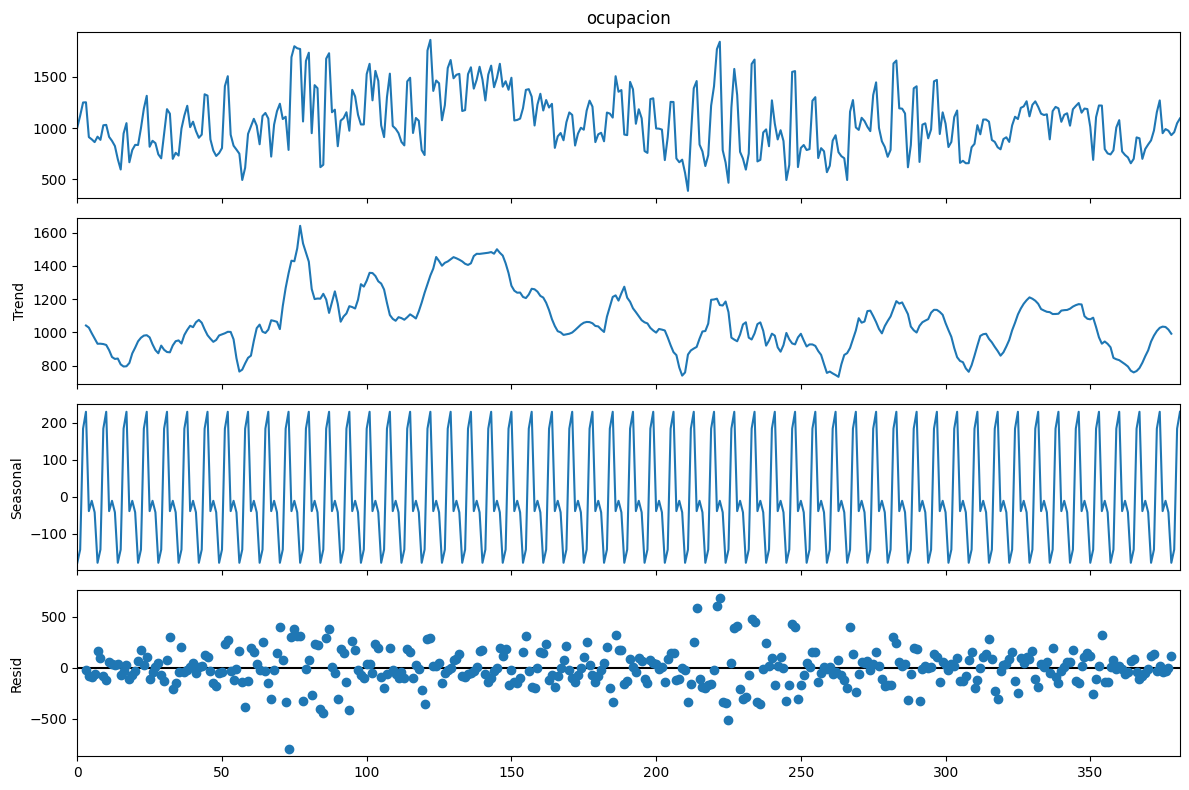

In [4]:
df = pd.read_csv('daily_occupancy_7.csv')
decomposition = seasonal_decompose(df['ocupacion'], model='additive', period=7)

# Plot  # Plotea componentes de seasonality
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [5]:
# Run ADF test on the trimmed data
result = adfuller(df['ocupacion'])

# Print ADF test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -2.9403786036244877
p-value: 0.04084998321633861
Critical Values:
   1%: -3.448294490928673
   5%: -2.869447722240253
   10%: -2.570982681065269


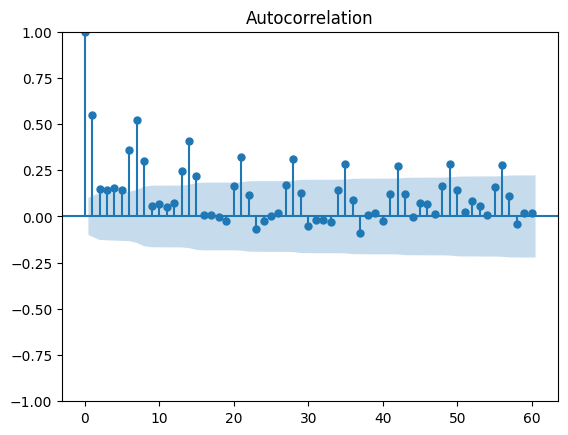

In [6]:
plot_acf(df['ocupacion'], lags=60)
plt.show()


<Figure size 1200x500 with 0 Axes>

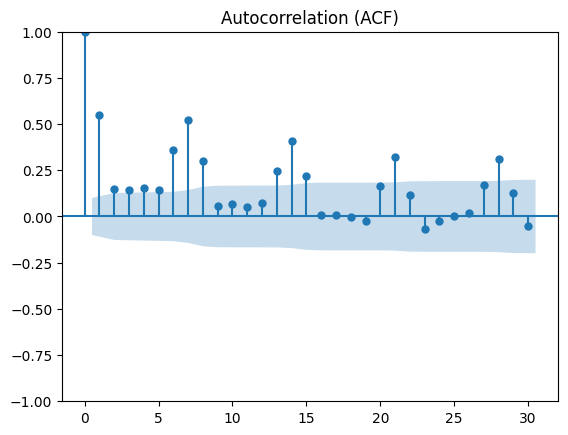

<Figure size 1200x500 with 0 Axes>

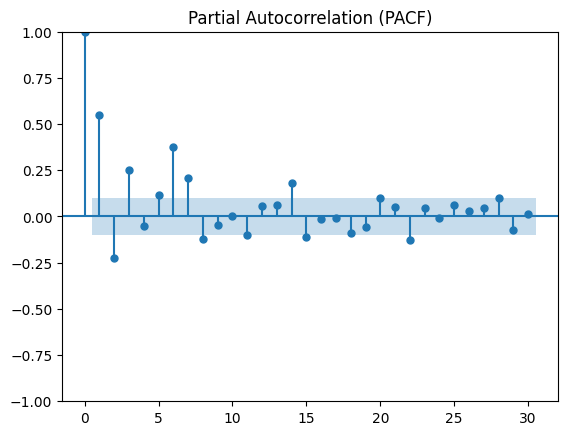

In [7]:
plt.figure(figsize=(12, 5))
plot_acf(df['ocupacion'], lags=30)
plt.title("Autocorrelation (ACF)")
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(df['ocupacion'], lags=30)
plt.title("Partial Autocorrelation (PACF)")
plt.show()


In [8]:
print([f'lag_{i}' for i in range(1,8)])

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']


## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 351, number of used features: 4
[LightGBM] [Info] Start training from score 1079.415954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

'\n# Save to CSV\nresults_df.to_csv("predictionslgbm.csv", index=False)\n\n#Infer signature\nsignature = infer_signature(X_train, model.predict(X_train))\n\nwith mlflow.start_run():    \n    # declarar parametros\n    mlflow.log_param("n_estimators", n_estimators)\n    mlflow.log_param("min_child_samples", min_child_samples)\n    mlflow.log_param("max_depth", max_depth)\n    mlflow.log_param("num_leaves", num_leaves)\n    mlflow.log_param("reg_alpha", reg_alpha)\n    mlflow.log_param("reg_lambda", reg_lambda)\n    mlflow.log_param("random_state", random_state)\n\n\n    # declarar metricas puedes declarar muchas metricas mas\n    mlflow.log_metric("MAE", mae)\n    mlflow.log_metric("RMSE", rmse)\n    mlflow.log_metric("MPE", mpe)\n    # registrar modelo\n    mlflow.sklearn.log_model(model, "model",\n                              registered_model_name="LightGBM_Holiday_5Lags",\n                              signature=signature)\n    # registrar artifacts\n    mlflow.log_artifact("predict

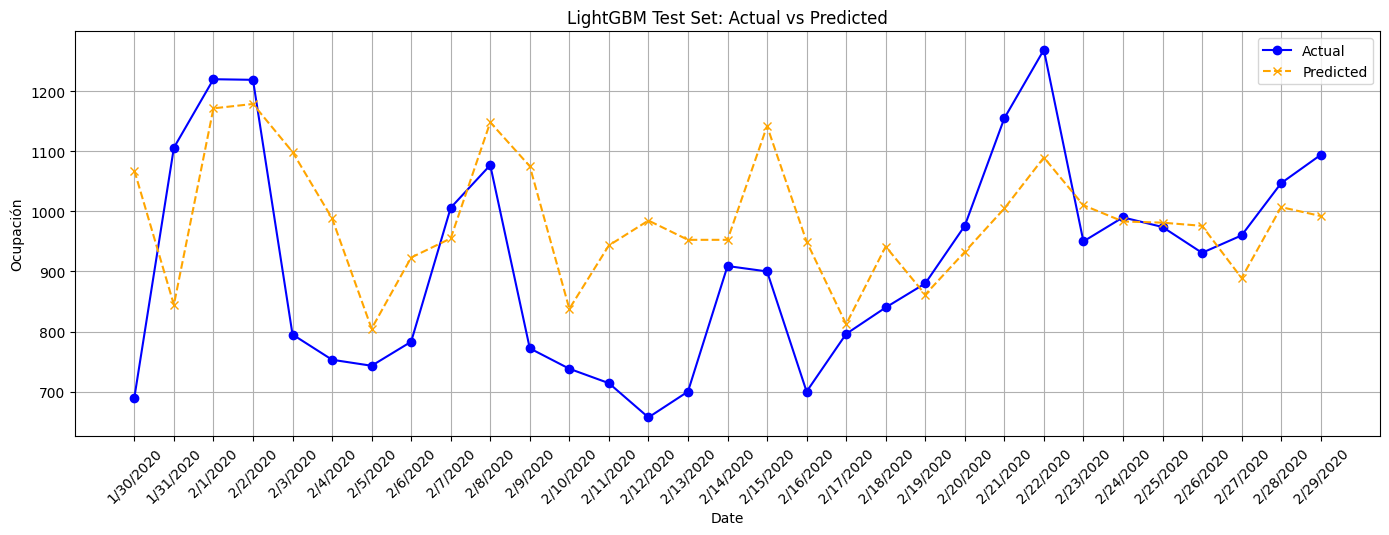

In [8]:
#Set tracking URI and experiment
#mlflow.set_tracking_uri("http://localhost:5001")
#mlflow.set_experiment("Oumaji_Occupancy")

# Cargamos el dataset y dividimos en targetCols y featureCols
df = pd.read_csv('daily_occupancy_7.csv')
#df = pd.read_csv('weekly_occupancy.csv')
featureCols = ['dia_festivo','semana_ano','lag_1','lag_2','lag_4']
targetCol = 'ocupacion'
X = df[featureCols]
y = df[targetCol]

# Split
splitIndex = int(len(df) * 0.921) 


X_train, X_test = X.iloc[:splitIndex], X.iloc[splitIndex:]
y_train, y_test = y.iloc[:splitIndex], y.iloc[splitIndex:]

#Parameters
n_estimators = 1000
min_child_samples = 60
learning_rate = 0.02
max_depth = -1
num_leaves = 31
reg_alpha = 1
reg_lambda = 1
random_state = 42

# Train
model = lgb.LGBMRegressor(
    
n_estimators = n_estimators, 
min_child_samples = min_child_samples, 
learning_rate = learning_rate,
max_depth = max_depth, 
num_leaves = num_leaves, 
reg_alpha = reg_alpha, 
reg_lambda = reg_lambda, 
random_state = random_state

)

model.fit(X_train, y_train)

# Predicciones y Evaluaciones
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mpe = np.mean((y_test - y_pred) / y_test) * 100
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")

# Guardamos resultados
results_df = pd.DataFrame({
    "date": df.iloc[X_test.index]["fecha"].values,
    "y_true": y_test.values,
    "y_pred": y_pred
})

#Plot # Reset index so we can use dates on x-axis (if available)
test_dates = df.iloc[X_test.index]['fecha'] if 'fecha' in df.columns else range(len(y_test))

# Plot predictions vs actuals for test set
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual', color='blue', marker='o')
plt.plot(test_dates, y_pred, label='Predicted', color='orange', linestyle='--', marker='x')
plt.title('LightGBM Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Ocupación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
# plt.savefig("test_vs_actual.png")

"""
# Save to CSV
results_df.to_csv("predictionslgbm.csv", index=False)

#Infer signature
signature = infer_signature(X_train, model.predict(X_train))

with mlflow.start_run():    
    # declarar parametros
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("min_child_samples", min_child_samples)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("num_leaves", num_leaves)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("random_state", random_state)
    
    
    # declarar metricas puedes declarar muchas metricas mas
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MPE", mpe)
    # registrar modelo
    mlflow.sklearn.log_model(model, "model",
                              registered_model_name="LightGBM_Holiday_5Lags",
                              signature=signature)
    # registrar artifacts
    mlflow.log_artifact("predictionslgbm.csv")
    mlflow.log_artifact("test_vs_actual.png")
    

# Optional cleanup
os.remove("predictionslgbm.csv")
os.remove("test_vs_actual.png")
"""

In [6]:
y_test

351     690
352    1106
353    1220
354    1219
355     795
356     753
357     743
358     783
359    1006
360    1077
361     772
362     738
363     714
364     657
365     700
366     909
367     900
368     700
369     796
370     840
371     880
372     976
373    1155
374    1269
375     950
376     990
377     974
378     931
379     960
380    1047
381    1094
Name: ocupacion, dtype: int64

In [73]:
df

,fecha,ocupacion,cuartos,dia_festivo,semana_ano,mes,trimestre,ano,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,semana_inicio
0,2/13/2019,1006,506,0,7,2,1,2019,0,0,0,0,0,0,0,2/11/2019
1,2/14/2019,1121,560,0,7,2,1,2019,1006,0,0,0,0,0,0,2/11/2019
2,2/15/2019,1249,584,0,7,2,1,2019,1121,1006,0,0,0,0,0,2/11/2019
3,2/16/2019,1251,590,0,7,2,1,2019,1249,1121,1006,0,0,0,0,2/11/2019
4,2/17/2019,912,445,0,7,2,1,2019,1251,1249,1121,1006,0,0,0,2/11/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2/25/2020,974,448,0,9,2,1,2020,990,950,1269,1155,976,880,840,2/24/2020
378,2/26/2020,931,425,0,9,2,1,2020,974,990,950,1269,1155,976,880,2/24/2020
379,2/27/2020,960,437,0,9,2,1,2020,931,974,990,950,1269,1155,976,2/24/2020
380,2/28/2020,1047,480,0,9,2,1,2020,960,931,974,990,950,1269,1155,2/24/2020


## CatBoost

0:	learn: 293.7456079	test: 237.3738899	best: 237.3738899 (0)	total: 147ms	remaining: 2m 27s
1:	learn: 292.7453139	test: 237.3086773	best: 237.3086773 (1)	total: 148ms	remaining: 1m 13s
2:	learn: 291.7922433	test: 236.3125606	best: 236.3125606 (2)	total: 149ms	remaining: 49.4s
3:	learn: 291.0038917	test: 236.0179623	best: 236.0179623 (3)	total: 149ms	remaining: 37.1s
4:	learn: 290.3866858	test: 235.5821233	best: 235.5821233 (4)	total: 149ms	remaining: 29.7s
5:	learn: 289.5525580	test: 235.0809902	best: 235.0809902 (5)	total: 150ms	remaining: 24.8s
6:	learn: 288.6499343	test: 234.0121316	best: 234.0121316 (6)	total: 150ms	remaining: 21.3s
7:	learn: 287.9805328	test: 233.4365882	best: 233.4365882 (7)	total: 151ms	remaining: 18.7s
8:	learn: 287.1343734	test: 232.7717412	best: 232.7717412 (8)	total: 151ms	remaining: 16.7s
9:	learn: 286.2650368	test: 232.7681304	best: 232.7681304 (9)	total: 152ms	remaining: 15s
10:	learn: 285.3247242	test: 231.8536461	best: 231.8536461 (10)	total: 152ms	rem

C:\Users\jlaza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'CatBoost' already exists. Creating a new version of this model...
2025/05/22 13:18:03 INFO mlflow.store.model_registry.abstract_sto

🏃 View run casual-cow-629 at: http://localhost:5001/#/experiments/176230793224478268/runs/6b9f3becd06b402c8dcef80ffced99a7
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


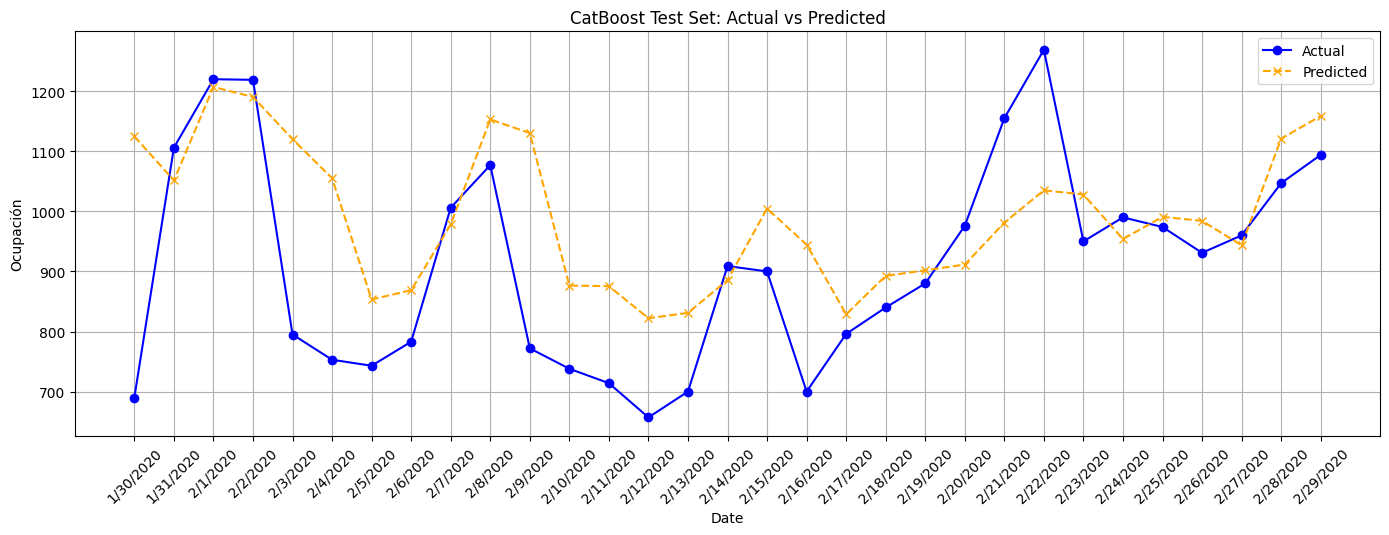

In [43]:
# Set tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Cargamos el dataset y dividimos en targetCols y featureCols
df = pd.read_csv('daily_occupancy_7.csv')
featureCols = ['dia_festivo', 'semana_ano', 'mes', 'trimestre', 'ano'] + [f'lag_{i}' for i in range(1, 8)]
targetCol = 'ocupacion'
X = df[featureCols]
y = df[targetCol]

# Split: 30-día test set
splitIndex = int(len(df) * 0.921)
X_train, X_test = X.iloc[:splitIndex], X.iloc[splitIndex:]
y_train, y_test = y.iloc[:splitIndex], y.iloc[splitIndex:]

# CatBoost params

iterations = 1000
learning_rate = 0.01
depth = 4
random_seed = 42
l2_leaf_reg = 10

# Train
model = CatBoostRegressor(iterations = iterations, learning_rate = learning_rate, depth = depth, loss_function = 'RMSE', random_seed = random_seed, l2_leaf_reg = l2_leaf_reg )
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predicciones y Evaluaciones
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mpe = np.mean((y_test - y_pred) / y_test) * 100
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")

# Guardamos resultados
results_df = pd.DataFrame({
    "date": df.iloc[X_test.index]["fecha"].values,
    "y_true": y_test.values,
    "y_pred": y_pred
})

# Plot
test_dates = df.iloc[X_test.index]['fecha'] if 'fecha' in df.columns else range(len(y_test))
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual', color='blue', marker='o')
plt.plot(test_dates, y_pred, label='Predicted', color='orange', linestyle='--', marker='x')
plt.title('CatBoost Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Ocupación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("test_vs_actual_catboost.png")
results_df.to_csv("predictions_catboost.csv", index=False)

# Infer signature
signature = infer_signature(X_train, model.predict(X_train))

with mlflow.start_run():
    
    mlflow.log_param("iterations", iterations)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("depth", depth)
    mlflow.log_param("random_seed", random_seed)
    mlflow.log_param("l2_leaf_reg", l2_leaf_reg)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MPE", mpe)

    mlflow.sklearn.log_model(model, "model", registered_model_name="CatBoost", signature=signature)
    mlflow.log_artifact("predictions_catboost.csv")
    mlflow.log_artifact("test_vs_actual_catboost.png")

# Optional cleanup
os.remove("predictions_catboost.csv")
os.remove("test_vs_actual_catboost.png")


## XGBoost

MAE: 108.85
Train RMSE: 148.83
Test RMSE: 140.70
Mean Percentage Error (MPE): -6.73%


Registered model 'XGBoost' already exists. Creating a new version of this model...
2025/05/22 14:04:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 3
Created version '3' of model 'XGBoost'.


🏃 View run youthful-hen-43 at: http://localhost:5001/#/experiments/176230793224478268/runs/e0e81b7224da49338bc8b5f2cd7cfbb4
🧪 View experiment at: http://localhost:5001/#/experiments/176230793224478268


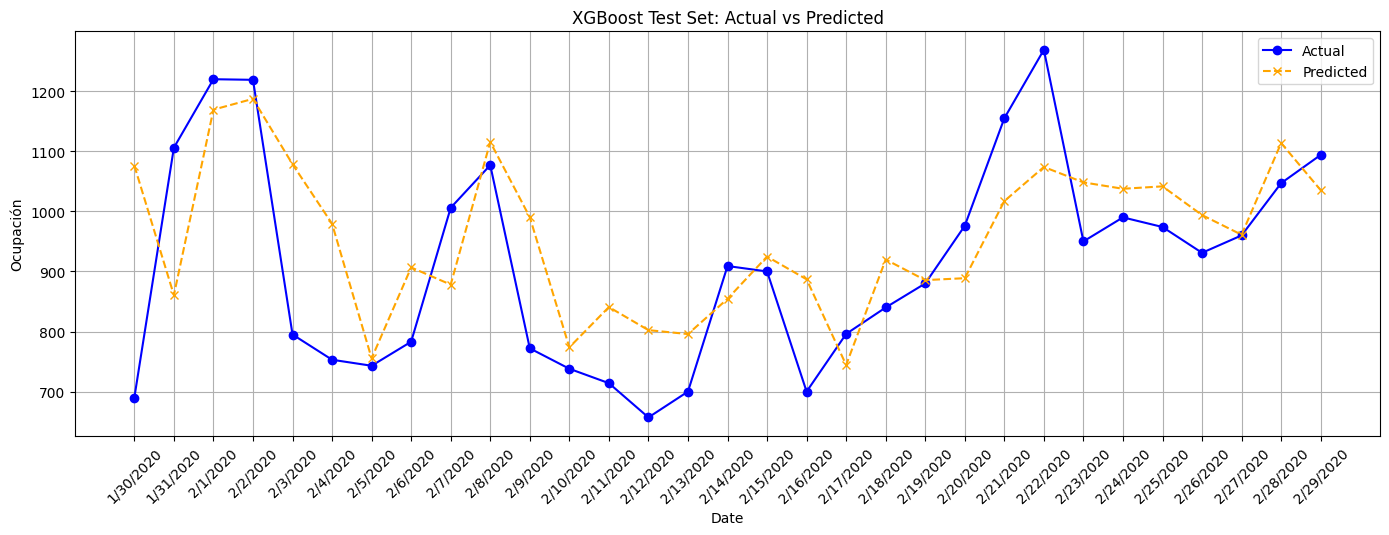

In [ ]:
# Set tracking URI and experiment
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Occupancy")

# Load data
df = pd.read_csv('daily_occupancy_7.csv')
feature_cols = ['dia_festivo', 'lag_1', 'lag_2','lag_3', 'lag_4','lag_5','lag_6']
target_col = 'ocupacion'
X = df[feature_cols]
y = df[target_col]

# Time-aware train-test split
split_index = int(len(df) * 0.921)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]



# Parameters
n_estimators = 1050
learning_rate = 0.01
max_depth = 2
subsample = 1 
gamma = 1
reg_alpha = 0.5
reg_lambda = 0.5
colsample_bytree = 0.9
random_state = 42

# Model with fixed regularization
model = XGBRegressor(
    
    n_estimators = n_estimators,
    learning_rate = learning_rate, 
    max_depth = max_depth,
    subsample = subsample, 
    gamma = gamma,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    colsample_bytree = colsample_bytree,
    random_state = random_state,  
    objective='reg:squarederror'
)

# Scoring function
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Model Fit
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mpe = np.mean((y_test - y_pred) / y_test) * 100
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

test_dates = df.iloc[X_test.index]['fecha'] if 'fecha' in df.columns else range(len(y_test))
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual', color='blue', marker='o')
plt.plot(test_dates, y_pred, label='Predicted', color='orange', linestyle='--', marker='x')
plt.title('XGBoost Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Ocupación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig("test_vs_actual_XGBoost.png")
results_df.to_csv("predictions_XGBoost.csv", index=False)

print(f"MAE: {mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Mean Percentage Error (MPE): {mpe:.2f}%")


with mlflow.start_run():
    
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("subsample", subsample)
    mlflow.log_param("gamma", gamma)
    mlflow.log_param("reg_alpha", reg_alpha)
    mlflow.log_param("reg_lambda", reg_lambda)
    mlflow.log_param("colsample_bytree", colsample_bytree)    
    mlflow.log_param("random_state", random_state)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MPE", mpe)

    mlflow.sklearn.log_model(model, "model", registered_model_name="XGBoost", signature=signature)
    mlflow.log_artifact("predictions_XGBoost.csv")
    mlflow.log_artifact("test_vs_actual_XGBoost.png")

# Optional cleanup
os.remove("predictions_XGBoost.csv")
os.remove("test_vs_actual_XGBoost.png")


